# On Improving the Backjump Level in PB Solvers

This document provides a complete analysis of the performance of the pseudo-Boolean solver *Sat4j* when trying to improve its backjump levels by continuing the conflict analysis until the backjump level is reached (unless it is the top one) and weakening away any literal that can be to preserve the assertion level.

By default, this document is **not** dynamic, so as to be readable on GitLab.
You may switch to a dynamic document by setting the variable `dynamic` to `True`, and re-run this Jupyter Notebook (the serialized results of the campaign are also available in this directory).
Note that [*Metrics 1.0.3*](https://pypi.org/project/crillab-metrics/1.0.3/) must be installed in your environment to run this notebook.

In [1]:
dynamic = False
figsize = (10, 7)

## Loading the Experiments

First, let us load the experiments with *Metrics*.
We note that an experiment will be considered as successfull when the solver has been able to decide whether the input formula is `SATISFIABLE` or `UNSATISFIABLE`.
Otherwise, the solver did not have enough time to decide the satisfiability of the formula, and either outputed `UNKNOWN` or nothing (if it did not have enough time to handle the `SIGTERM` signal).

In [2]:
from matplotlib import pyplot as plt
from metrics.wallet import Analysis, import_analysis
from os import path
from pandas import isnull

In [3]:
campaign_name = 'backjump-level'

if path.exists(f'{campaign_name}.json'):
    # Loading the serialized campaign.
    with open(f'{campaign_name}.json') as json_analysis:
        campaign = import_analysis(json_analysis.read())

else:
    # Extracting the campaign from the log files of the experiments, and serializing it for later use.
    campaign = Analysis(f'{campaign_name}.yml',
                        is_success=lambda xp: xp['decision'] in ('SATISFIABLE', 'UNSATISFIABLE'))
    with open(f'{campaign_name}.json', 'w') as json_analysis:
        json_analysis.write(campaign.export())

We now need to compute the actual number of derivations steps, as it is contained in two values for the new approaches.

In [4]:
campaign = campaign.map(
    'total-steps',
    lambda x: x['steps'] if isnull(x['steps-after']) else x['steps'] + x['steps-after'])

We now keep the list of all the considered solvers to easily retrieve them later on.

In [5]:
all_solvers = campaign.campaign_df.xp_ware_names

In [6]:
solver_map = {
    'default': 'Stop at First Assertive Constraint',
    'naive': 'Analyze until Backjump Level',
    'toplevel': 'Analyze until Backjump Level unless Top Level',
}

## Checking Consistency

Now that we have loaded the experiments, we must check that the results are consistent.
More precisely, we must make sure that all configurations agree on the satisfiability of each benchmark they solve.
If this is not the case, it probably means that one of the strategies is buggy.
We note that found models are already validated by the environment.

In [7]:
 for analysis_by_input in campaign.groupby('input'):
    decisions = analysis_by_input.campaign_df.data_frame['decision'].unique()
    assert 'SATISFIABLE' not in decisions or 'UNSATISFIABLE' not in decisions

## Comparison with the Default Strategy

In [8]:
campaign.get_scatter_plot(scatter_col='cpu_time',
                          xp_ware_x='default',
                          xp_ware_y='toplevel',     
                          
                          title='Scatter-Plot of the Runtime (in seconds)',
                          color_col='family',
                          xp_ware_name_map=solver_map,
                                  
                          x_min=0.1, x_max=1200, logx=True,
                          y_min=0.1, y_max=1200, logy=True,
                                 
                          bbox_to_anchor=(1, 0.5),
                          legend_location='center left',
                          ncol_legend=2,
                             
                          figsize=figsize,
                                 
                          dynamic=dynamic)

<AxesSubplot:title={'center':'Comparison of Stop at First Assertive Constraint and Analyze until Backjump Level unless Top Level'}, xlabel='Stop at First Assertive Constraint', ylabel='Analyze until Backjump Level unless Top Level'>

In [9]:
campaign.sub_analysis('experiment_ware', ['default', 'toplevel'])\
        .get_only_common_success()\
        .get_scatter_plot(scatter_col='conflicts',
                          xp_ware_x='default',
                          xp_ware_y='toplevel',     
                          
                          title='Scatter-Plot of the Number of Conflicts',
                          color_col='family',
                          xp_ware_name_map=solver_map,
                                  
                          x_min=0.9, x_max=100000, logx=True,
                          y_min=0.9, y_max=100000, logy=True,
                                 
                          bbox_to_anchor=(1, 0.5),
                          legend_location='center left',
                          ncol_legend=2,
                             
                          figsize=figsize,
                                 
                          dynamic=dynamic)

<AxesSubplot:title={'center':'Comparison of Stop at First Assertive Constraint and Analyze until Backjump Level unless Top Level'}, xlabel='Stop at First Assertive Constraint', ylabel='Analyze until Backjump Level unless Top Level'>

In [10]:
campaign.sub_analysis('experiment_ware', ['default', 'toplevel'])\
        .get_only_common_success()\
        .get_scatter_plot(scatter_col='total-steps',
                          xp_ware_x='default',
                          xp_ware_y='toplevel',     
                          
                          title='Scatter-Plot of the Number of Cancellations',
                          color_col='family',
                          xp_ware_name_map=solver_map,
                                  
                          x_min=0.9, x_max=2000000, logx=True,
                          y_min=0.9, y_max=2000000, logy=True,
                                 
                          bbox_to_anchor=(1, 0.5),
                          legend_location='center left',
                          ncol_legend=2,
                             
                          figsize=figsize,
                                 
                          dynamic=dynamic)

<AxesSubplot:title={'center':'Comparison of Stop at First Assertive Constraint and Analyze until Backjump Level unless Top Level'}, xlabel='Stop at First Assertive Constraint', ylabel='Analyze until Backjump Level unless Top Level'>

## Comparison with the `until-bjlevel` Strategy

In [11]:
campaign.get_scatter_plot(scatter_col='cpu_time',
                          xp_ware_x='naive',
                          xp_ware_y='toplevel',     
                          
                          title='Scatter-Plot of the Runtime (in seconds)',
                          color_col='family',
                          xp_ware_name_map=solver_map,
                                  
                          x_min=0.1, x_max=1200, logx=True,
                          y_min=0.1, y_max=1200, logy=True,
                                 
                          bbox_to_anchor=(1, 0.5),
                          legend_location='center left',
                          ncol_legend=2,
                             
                          figsize=figsize,
                                 
                          dynamic=dynamic)

<AxesSubplot:title={'center':'Comparison of Analyze until Backjump Level and Analyze until Backjump Level unless Top Level'}, xlabel='Analyze until Backjump Level', ylabel='Analyze until Backjump Level unless Top Level'>

<AxesSubplot:title={'center':'Comparison of Analyze until Backjump Level and Analyze until Backjump Level unless Top Level'}, xlabel='Analyze until Backjump Level', ylabel='Analyze until Backjump Level unless Top Level'>

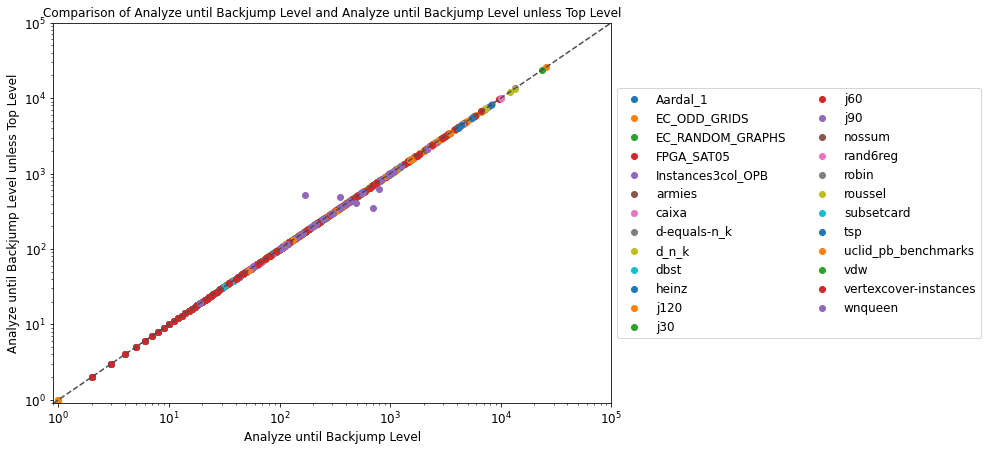

In [12]:
campaign.sub_analysis('experiment_ware', ['toplevel', 'naive'])\
        .get_only_common_success()\
        .get_scatter_plot(scatter_col='conflicts',
                          xp_ware_x='naive',
                          xp_ware_y='toplevel',     
                          
                          title='Scatter-Plot of the Number of Conflicts',
                          color_col='family',
                          xp_ware_name_map=solver_map,
                                  
                          x_min=0.9, x_max=100000, logx=True,
                          y_min=0.9, y_max=100000, logy=True,
                                 
                          bbox_to_anchor=(1, 0.5),
                          legend_location='center left',
                          ncol_legend=2,
                             
                          figsize=figsize,
                                 
                          dynamic=dynamic)

<AxesSubplot:title={'center':'Comparison of Analyze until Backjump Level and Analyze until Backjump Level unless Top Level'}, xlabel='Analyze until Backjump Level', ylabel='Analyze until Backjump Level unless Top Level'>

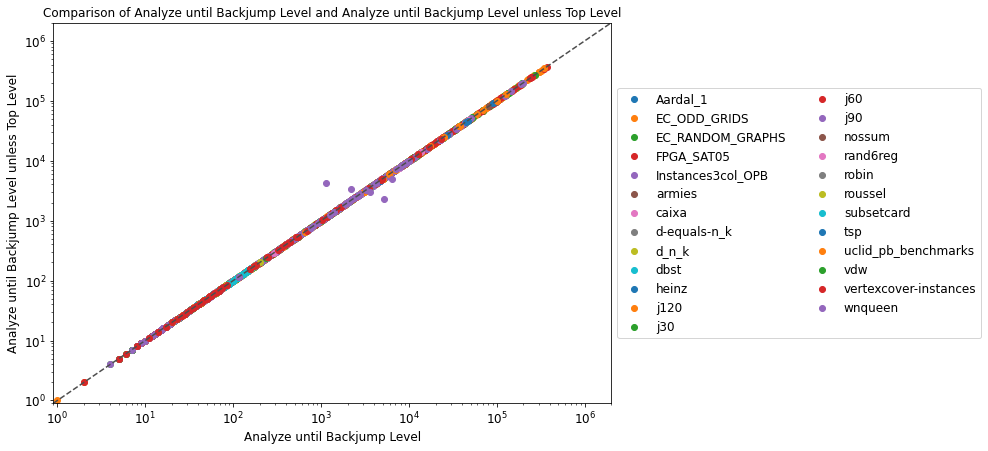

In [13]:
campaign.sub_analysis('experiment_ware', ['toplevel', 'naive'])\
        .get_only_common_success()\
        .get_scatter_plot(scatter_col='total-steps',
                          xp_ware_x='naive',
                          xp_ware_y='toplevel',     
                          
                          title='Scatter-Plot of the Number of Cancellations',
                          color_col='family',
                          xp_ware_name_map=solver_map,
                                  
                          x_min=0.9, x_max=2000000, logx=True,
                          y_min=0.9, y_max=2000000, logy=True,
                                 
                          bbox_to_anchor=(1, 0.5),
                          legend_location='center left',
                          ncol_legend=2,
                             
                          figsize=figsize,
                                 
                          dynamic=dynamic)

## Improved Backjumps Compared to the `until-bjlevel` Strategy

In [14]:
campaign.sub_analysis('experiment_ware', ['toplevel', 'naive'])\
        .get_only_common_success()\
        .get_scatter_plot(scatter_col='sub-optimal',
                          xp_ware_x='naive',
                          xp_ware_y='toplevel',     
                          
                          title='Number of Sub-Optimal Conflict Analyses',
                          color_col='family',
                          xp_ware_name_map=solver_map,
                                  
                          x_min=0.9, x_max=10000, logx=True,
                          y_min=0.9, y_max=10000, logy=True,
                                 
                          bbox_to_anchor=(1, 0.5),
                          legend_location='center left',
                          ncol_legend=2,
                             
                          figsize=figsize,
                                 
                          dynamic=dynamic)

<AxesSubplot:title={'center':'Comparison of Analyze until Backjump Level and Analyze until Backjump Level unless Top Level'}, xlabel='Analyze until Backjump Level', ylabel='Analyze until Backjump Level unless Top Level'>

<AxesSubplot:title={'center':'Comparison of Analyze until Backjump Level and Analyze until Backjump Level unless Top Level'}, xlabel='Analyze until Backjump Level', ylabel='Analyze until Backjump Level unless Top Level'>

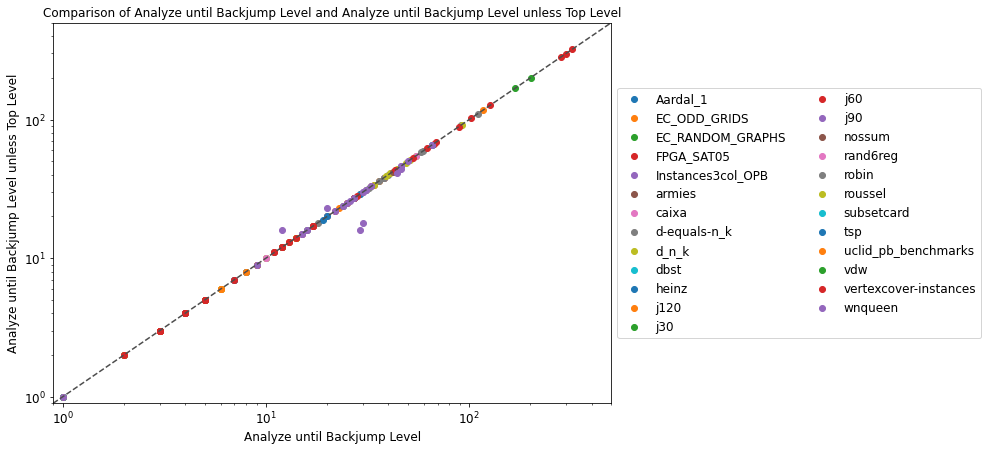

In [15]:
campaign.sub_analysis('experiment_ware', ['toplevel', 'naive'])\
        .get_only_common_success()\
        .get_scatter_plot(scatter_col='improved-backjumps',
                          xp_ware_x='naive',
                          xp_ware_y='toplevel',     
                          
                          title='Number of Improved Backjumps',
                          color_col='family',
                          xp_ware_name_map=solver_map,
                                  
                          x_min=0.9, x_max=500, logx=True,
                          y_min=0.9, y_max=500, logy=True,
                                 
                          bbox_to_anchor=(1, 0.5),
                          legend_location='center left',
                          ncol_legend=2,
                             
                          figsize=figsize,
                                 
                          dynamic=dynamic)

<AxesSubplot:title={'center':'Comparison of Analyze until Backjump Level and Analyze until Backjump Level unless Top Level'}, xlabel='Analyze until Backjump Level', ylabel='Analyze until Backjump Level unless Top Level'>

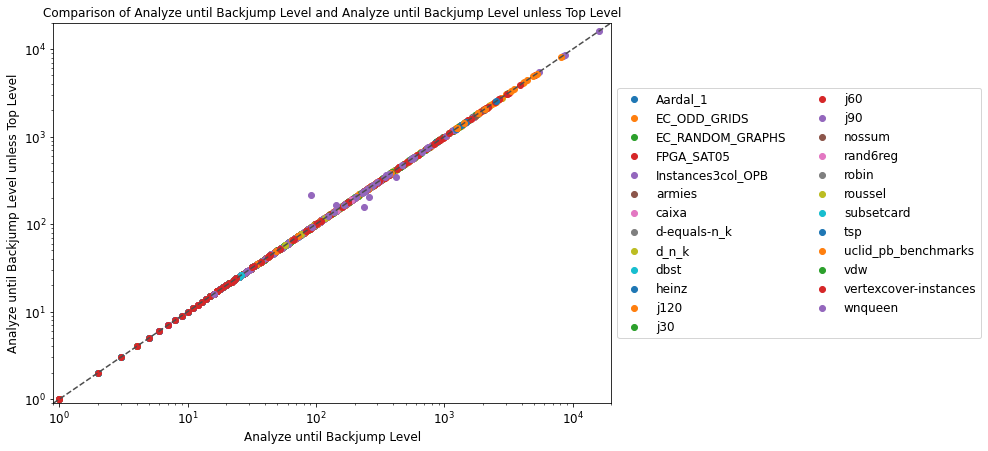

In [16]:
campaign.sub_analysis('experiment_ware', ['toplevel', 'naive'])\
        .get_only_common_success()\
        .get_scatter_plot(scatter_col='steps-after',
                          xp_ware_x='naive',
                          xp_ware_y='toplevel',     
                          
                          title='Number of Additional Derivation Steps',
                          color_col='family',
                          xp_ware_name_map=solver_map,
                                  
                          x_min=0.9, x_max=20000, logx=True,
                          y_min=0.9, y_max=20000, logy=True,
                                 
                          bbox_to_anchor=(1, 0.5),
                          legend_location='center left',
                          ncol_legend=2,
                             
                          figsize=figsize,
                                 
                          dynamic=dynamic)